In [1]:
import logging
import time
from os import path

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold

from definitions import DATA_PATH
from definitions import LOGS_PATH
import src.framingham.aha_frs_cvd as aha_frs_cvd
import src.lib.optimal_threhold_related as thres
import src.lib.fairness_tests as fair

In [5]:
time_stamp = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())

log_files = path.join(LOGS_PATH, 'log_benchmark.txt')
logging.basicConfig(filename=log_files+str(time_stamp), level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logging.debug('This is a log message.')

In [6]:
#Please identify the framingham features
#framing_features= ['Gender','AGE','MEDIAN_VALUE_Chol','MEDIAN_VALUE_HDL-C','MEDIAN_SYSTOLIC','Smoking','T2DM_CNT','HTN_DRUG_CNT','Race']
framing_features = ['Gender', 'AGE', 'RECENT_VALUE_Chol', 'RECENT_VALUE_HDL-C', 'RECENT_SYSTOLIC', 'Smoking',
                    'T2DM_CNT', 'HTN_DRUG_CNT', 'Race']

In [7]:
def compute_ind_frs(df):
    score_list = []
    for index, row in df.iterrows():
        X = row[framing_features].values
        score = aha_frs_cvd.frs(*X)
        score_list.append(score)
    df['frs'] = pd.Series(score_list)
    return df

In [8]:
def predict_by_framingham(df: object, reset_index: object = False) -> object:
    # if the input df is cross validation split, need to reset index
    if reset_index:
        df.reset_index(drop=True)
    y = df.Class.values
    df = compute_ind_frs(df)
    print("after compute", df.shape)
    x = df[(df['Gender'] == 'F') & (df['Race'] == 'W')]['frs']

    #mean_frs_women_w = np.mean(df[(df['Gender']=='F') & (df['Race']=='W')]['frs'])
    #mean_frs_women_b = np.mean(df[(df['Gender']=='F') & (df['Race']=='B')]['frs'])
    #mean_frs_men_w = np.mean(df[(df['Gender']=='M') & (df['Race']=='W')]['frs'])
    #mean_frs_men_b = np.mean(df[(df['Gender']=='M') & (df['Race']=='B')]['frs'])
    #print(mean_frs_women_w)
    #print(mean_frs_women_b)
    #print(mean_frs_men_w)
    #print(mean_frs_men_b)
    mean_frs_women_w = -29.18
    mean_frs_women_b = 86.61
    mean_frs_men_w = 61.18
    mean_frs_men_b = 19.54
    risk_list = []
    for index, row in df.iterrows():
        gender = row['Gender']
        race = row['Race']
        risk = 0

        if gender == 'F':
            if race == 'W':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_women_w, gender='F', race='W')
            elif race == 'B':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_women_b, gender='F', race='B')
            else:
                print('1',race)
        elif gender == 'M':
            if race == 'W':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_men_w, gender='M', race='W')
            elif race == 'B':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_men_b, gender='M', race='B')
            else:
                print('2', race)
        else:
            print('3', gender)
        # if np.isnan(risk):
        #     print(index)

        risk_list.append(risk)
    df['risk'] = pd.Series(risk_list)
    print(df.risk.unique())
    print(len(risk_list))
    df.loc[df['risk'] > 0.075, 'predict'] = 1
    df.loc[df['risk'] <= 0.075, 'predict'] = 0
        
    cm = confusion_matrix(y,df['predict'].values)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
    print(df.predict.unique())
    #save the interim output
    df.to_csv(path.join(DATA_PATH, 'framingham_result.csv'))

    print('accuracy', accuracy_score(y, df['predict'].values))
    print('roc AUC', roc_auc_score(y, df['risk'].values))
    print('precision', precision_score(y, df['predict'].values))
    print('recall', recall_score(y, df['predict'].values))
    print("ap", average_precision_score(y, df['risk'].values))
    
    return accuracy_score(y, df['predict'].values), roc_auc_score(y, df['risk'].values), \
           precision_score(y, df['predict'].values), recall_score(y, df['predict'].values), \
           average_precision_score(y, df['risk'].values)

In [2]:
data_path='/Users/lifuchen/Desktop/research'
df = pd.read_csv(path.join(data_path, 'framingham_data.csv'))
print(df.shape)
df.head()


(109490, 100)


,GRID,Gender,Race_B,Race_W,AGE,DURATION_BF2007,Smoking,MAX_BMI_missing,MAX_VALUE_Chol_missing,MAX_VALUE_Creat_missing,...,CNT_MedCode_4917,CNT_MedCode_5487,CNT_MedCode_5640,CNT_MedCode_6918,CNT_MedCode_798302,CNT_MedCode_83367,CNT_MedCode_836,Class,HTN_DRUG_CNT,Race
0,R247513794,F,0,1,59,5411,1,0,0,1,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0,0.0,W
1,R239544414,M,0,1,47,397,1,0,1,0,...,0.0,1.0,2.0,19.0,0.0,0.0,0.0,0,54.0,W
2,R215940379,F,0,1,51,2738,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14.0,W
3,R230872807,M,1,0,28,489,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,B
4,R227723582,F,0,1,41,1093,0,0,1,1,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0.0,W


after compute (109490, 101)
[0.03338799 0.04103137 0.01992129 ... 0.2582554  0.08743225 0.03090266]
109490
[0. 1.]
accuracy 0.7590282217554114
roc AUC 0.7331418523781482
precision 0.19187258112533492
recall 0.5248371335504886
ap 0.18518274016103173


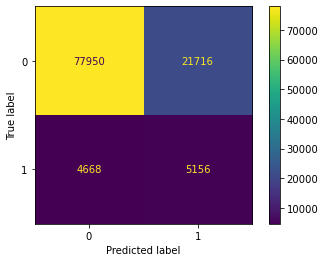

In [10]:
acc, roc, precision, recall, ap = predict_by_framingham(df)

In [11]:
df_2 = pd.read_csv(path.join(DATA_PATH, 'framingham_result.csv'))
df_2.head()

,Unnamed: 0,GRID,Gender,Race_B,Race_W,AGE,DURATION_BF2007,Smoking,MAX_BMI_missing,MAX_VALUE_Chol_missing,...,CNT_MedCode_6918,CNT_MedCode_798302,CNT_MedCode_83367,CNT_MedCode_836,Class,HTN_DRUG_CNT,Race,frs,risk,predict
0,0,R247513794,F,0,1,59,5411,1,0,0,...,0.0,0.0,0.0,0.0,0,0.0,W,-29.183407,0.033388,0.0
1,1,R239544414,M,0,1,47,397,1,0,1,...,19.0,0.0,0.0,0.0,0,54.0,W,60.421117,0.041031,0.0
2,2,R215940379,F,0,1,51,2738,0,1,1,...,0.0,0.0,0.0,0.0,0,14.0,W,-29.706701,0.019921,0.0
3,3,R230872807,M,1,0,28,489,0,0,1,...,0.0,0.0,0.0,0.0,0,0.0,B,17.399280,0.012906,0.0
4,4,R227723582,F,0,1,41,1093,0,0,1,...,0.0,0.0,0.0,0.0,0,0.0,W,-31.220169,0.004420,0.0


In [12]:
grouped = df_2.groupby(df_2.Race)
df_2_white = grouped.get_group("W")
df_2_black = grouped.get_group("B")

4109

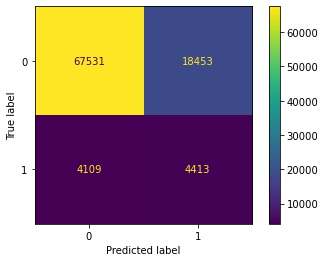

In [13]:
cm = confusion_matrix(df_2_white['Class'].values,df_2_white['predict'].values)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm[1,0]

In [14]:
print('roc AUC', roc_auc_score(df_2_white['Class'].values,df_2_white['predict'].values))

roc AUC 0.6516132469305784


10419

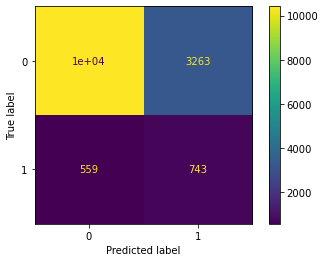

In [15]:
cm2 = confusion_matrix(df_2_black['Class'].values,df_2_black['predict'].values)
cm_display = ConfusionMatrixDisplay(cm2).plot()
cm2[0,0]

In [16]:
print('roc AUC', roc_auc_score(df_2_black['Class'].values,df_2_black['predict'].values))

roc AUC 0.6660859986019956


In [17]:
grouped_2 = df_2.groupby(df_2.Gender)
df_2_male = grouped_2.get_group("M")
df_2_female = grouped_2.get_group("F")

In [18]:
print('roc AUC', roc_auc_score(df_2_male['Class'].values,df_2_male['predict'].values))

roc AUC 0.6581322870679354


In [19]:
print('roc AUC', roc_auc_score(df_2_female['Class'].values,df_2_female['predict'].values))

roc AUC 0.6356554827340459


In [20]:
eod_race = fair.get_EOD(df_2_white['Class'].values,df_2_white['predict'].values,df_2_black['Class'].values,df_2_black['predict'].values)
eod_race

threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.30300000000000005
threshold:0.2, J-value:0.30300000000000005
threshold:0.30000000000000004, J-value:0.30300000000000005
threshold:0.4, J-value:0.30300000000000005
threshold:0.5, J-value:0.30300000000000005
threshold:0.6000000000000001, J-value:0.30300000000000005
threshold:0.7000000000000001, J-value:0.30300000000000005
threshold:0.8, J-value:0.30300000000000005
threshold:0.9, J-value:0.30300000000000005
True positive rate of class 1 is  0.518
threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.33299999999999996
threshold:0.2, J-value:0.33299999999999996
threshold:0.30000000000000004, J-value:0.33299999999999996
threshold:0.4, J-value:0.33299999999999996
threshold:0.5, J-value:0.33299999999999996
threshold:0.6000000000000001, J-value:0.33299999999999996
threshold:0.7000000000000001, J-value:0.33299999999999996
threshold:0.8, J-value:0.33299999999999996
threshold:0.9, J-value:0.33299999999999996
True positive rate of class 2 is  0.571


-0.052999999999999936

In [21]:
sp_race = fair.get_SP(df_2_white['Class'].values,df_2_white['predict'].values,df_2_black['Class'].values,df_2_black['predict'].values)
sp_race

threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.30300000000000005
threshold:0.2, J-value:0.30300000000000005
threshold:0.30000000000000004, J-value:0.30300000000000005
threshold:0.4, J-value:0.30300000000000005
threshold:0.5, J-value:0.30300000000000005
threshold:0.6000000000000001, J-value:0.30300000000000005
threshold:0.7000000000000001, J-value:0.30300000000000005
threshold:0.8, J-value:0.30300000000000005
threshold:0.9, J-value:0.30300000000000005
Positive prediction rate of class 1 is  0.242
threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.33299999999999996
threshold:0.2, J-value:0.33299999999999996
threshold:0.30000000000000004, J-value:0.33299999999999996
threshold:0.4, J-value:0.33299999999999996
threshold:0.5, J-value:0.33299999999999996
threshold:0.6000000000000001, J-value:0.33299999999999996
threshold:0.7000000000000001, J-value:0.33299999999999996
threshold:0.8, J-value:0.33299999999999996
threshold:0.9, J-value:0.33299999999999996
Positive prediction rate of class 

0.9063670411985018

In [22]:
eod_gender = fair.get_EOD(df_2_male['Class'].values,df_2_male['predict'].values,df_2_female['Class'].values,df_2_female['predict'].values)
eod_gender

threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.316
threshold:0.2, J-value:0.316
threshold:0.30000000000000004, J-value:0.316
threshold:0.4, J-value:0.316
threshold:0.5, J-value:0.316
threshold:0.6000000000000001, J-value:0.316
threshold:0.7000000000000001, J-value:0.316
threshold:0.8, J-value:0.316
threshold:0.9, J-value:0.316
True positive rate of class 1 is  0.658
threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.271
threshold:0.2, J-value:0.271
threshold:0.30000000000000004, J-value:0.271
threshold:0.4, J-value:0.271
threshold:0.5, J-value:0.271
threshold:0.6000000000000001, J-value:0.271
threshold:0.7000000000000001, J-value:0.271
threshold:0.8, J-value:0.271
threshold:0.9, J-value:0.271
True positive rate of class 2 is  0.423


0.23500000000000004

In [23]:
sp_gender = fair.get_SP(df_2_male['Class'].values,df_2_male['predict'].values,df_2_female['Class'].values,df_2_female['predict'].values)
sp_gender

threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.316
threshold:0.2, J-value:0.316
threshold:0.30000000000000004, J-value:0.316
threshold:0.4, J-value:0.316
threshold:0.5, J-value:0.316
threshold:0.6000000000000001, J-value:0.316
threshold:0.7000000000000001, J-value:0.316
threshold:0.8, J-value:0.316
threshold:0.9, J-value:0.316
Positive prediction rate of class 1 is  0.376
threshold:0.0, J-value:0.0
threshold:0.1, J-value:0.271
threshold:0.2, J-value:0.271
threshold:0.30000000000000004, J-value:0.271
threshold:0.4, J-value:0.271
threshold:0.5, J-value:0.271
threshold:0.6000000000000001, J-value:0.271
threshold:0.7000000000000001, J-value:0.271
threshold:0.8, J-value:0.271
threshold:0.9, J-value:0.271
Positive prediction rate of class 2 is  0.173


2.1734104046242777

In [ ]:
def predict_by_framingham_sample(df: object, reset_index: object = False) -> object:
    # if the input df is cross validation split, need to reset index
    if reset_index:
        df.reset_index(drop=True)
    y = df.Class.values
    df = compute_ind_frs(df)
    print("after compute", df.shape)
    x = df[(df['Gender'] == 'F') & (df['Race'] == 'W')]['frs']

    mean_frs_women_w = np.mean(df[(df['Gender']=='F') & (df['Race']=='W')]['frs'])
    mean_frs_women_b = np.mean(df[(df['Gender']=='F') & (df['Race']=='B')]['frs'])
    mean_frs_men_w = np.mean(df[(df['Gender']=='M') & (df['Race']=='W')]['frs'])
    mean_frs_men_b = np.mean(df[(df['Gender']=='M') & (df['Race']=='B')]['frs'])
    print(mean_frs_women_w)
    print(mean_frs_women_b)
    print(mean_frs_men_w)
    print(mean_frs_men_b)
    risk_list = []
    for index, row in df.iterrows():
        gender = row['Gender']
        race = row['Race']
        risk = 0

        if gender == 'F':
            if race == 'W':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_women_w, gender='F', race='W')
            elif race == 'B':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_women_b, gender='F', race='B')
            else:
                print('1',race)
        elif gender == 'M':
            if race == 'W':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_men_w, gender='M', race='W')
            elif race == 'B':
                risk = aha_frs_cvd.estimiate_risk(ind_frs=row['frs'], mean_frs=mean_frs_men_b, gender='M', race='B')
            else:
                print('2', race)
        else:
            print('3', gender)
        # if np.isnan(risk):
        #     print(index)

        risk_list.append(risk)
    df['risk'] = pd.Series(risk_list)
    print(df.risk.unique())
    print(len(risk_list))
    df.loc[df['risk'] > 0.075, 'predict'] = 1
    df.loc[df['risk'] <= 0.075, 'predict'] = 0

    cm = confusion_matrix(y,df['predict'].values)
    cm_display = ConfusionMatrixDisplay(cm).plot()

    print(df.predict.unique())
    #save the interim output
    df.to_csv(path.join(DATA_PATH, 'framingham_by_sample_result.csv'))

    print('accuracy', accuracy_score(y, df['predict'].values))
    print('roc AUC', roc_auc_score(y, df['risk'].values))
    print('precision', precision_score(y, df['predict'].values))
    print('recall', recall_score(y, df['predict'].values))
    print("ap", average_precision_score(y, df['risk'].values))

    return accuracy_score(y, df['predict'].values), roc_auc_score(y, df['risk'].values), \
           precision_score(y, df['predict'].values), recall_score(y, df['predict'].values), \
           average_precision_score(y, df['risk'].values)

In [ ]:
acc, roc, precision, recall, ap = predict_by_framingham_sample(df)

In [ ]:
df_3 = pd.read_csv(path.join(DATA_PATH, 'framingham_by_sample_result.csv'))
df_3.head()

In [ ]:
grouped_sample = df_3.groupby(df_2.Race)
df_3_white = grouped_sample.get_group("W")
df_3_black = grouped_sample.get_group("B")
grouped_sample_2 = df_3.groupby(df_2.Gender)
df_3_male = grouped_sample_2.get_group("M")
df_3_female = grouped_sample_2.get_group("F")

In [ ]:
print('roc AUC', roc_auc_score(df_3_white['Class'].values,df_3_white['predict'].values))
print('roc AUC', roc_auc_score(df_3_black['Class'].values,df_3_black['predict'].values))
print('roc AUC', roc_auc_score(df_3_male['Class'].values,df_3_male['predict'].values))
print('roc AUC', roc_auc_score(df_3_female['Class'].values,df_3_female['predict'].values))

In [ ]:
eod_race_sample = fair.get_EOD(df_3_white['Class'].values,df_3_white['predict'].values,df_3_black['Class'].values,df_3_black['predict'].values)
eod_race_sample

In [ ]:
sp_race_sample = fair.get_SP(df_3_white['Class'].values,df_3_white['predict'].values,df_3_black['Class'].values,df_3_black['predict'].values)
sp_race_sample

In [ ]:
eod_gender_sample = fair.get_EOD(df_3_male['Class'].values,df_3_male['predict'].values,df_3_female['Class'].values,df_3_female['predict'].values)
eod_gender_sample

In [ ]:
sp_gender_sample = fair.get_SP(df_3_male['Class'].values,df_3_male['predict'].values,df_3_female['Class'].values,df_3_female['predict'].values)
sp_gender_sample
